In [28]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from torch import optim
import os
import csv
from PIL import Image
import warnings
warnings.simplefilter('ignore')
from torchvision import datasets

#载入数据
trans = transforms.Compose((transforms.Resize((32,32)),transforms.ToTensor()))
train_set1 = list(datasets.MNIST('./num',train=True,transform=trans, download=False))[:30000]
train_set2 = list(datasets.MNIST('./num',train=True,transform=trans, download=False))[30000:]
#mnist中的test_set一共有1万张照片，这里我们把前5000张用作validation_set,后5000张用作test_set
val_set = list(datasets.MNIST('./num',train=False,transform=trans, download=False))[:5000]
test_set = list(datasets.MNIST('./num',train=False,transform=trans, download=False))[5000:]

train_loader = DataLoader(train_set1,batch_size=150,shuffle=True)
val_loader = DataLoader(val_set,batch_size=50,shuffle=True)
test_loader = DataLoader(test_set,batch_size=50,shuffle=True)


#构建resblock
class resblock(nn.Module):
    def __init__(self,ch_in,ch_out,stride=1):
        super(resblock,self).__init__()
        self.conv_1 = nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=stride,padding=1)
        self.bn_1 = nn.BatchNorm2d(ch_out)
        self.conv_2 = nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1)
        self.bn_2 = nn.BatchNorm2d(ch_out)
        self.ch_trans = nn.Sequential()
        if ch_in != ch_out:
            self.ch_trans = nn.Sequential(nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=stride),nn.BatchNorm2d(ch_out))
        #ch_trans表示通道数转变。因为要做short_cut,所以x_pro和x_ch的size应该完全一致
        
    def  forward(self,x):
        x_pro = F.relu(self.bn_1(self.conv_1(x)))
        x_pro = self.bn_2(self.conv_2(x_pro))
        
        #short_cut:
        x_ch = self.ch_trans(x)
        out = x_pro + x_ch
        out = F.relu(out)
        return out 
    
    
#搭建resnet
class Resnet18(nn.Module):
    def __init__(self,num_class):
        super(Resnet18,self).__init__()
        self.conv_1 = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,stride=3,padding=0),
        nn.BatchNorm2d(16))
        self.block1 = resblock(16,32,1) 
        self.block2 = resblock(32,64,1) 
        self.block3 = resblock(64,128,2)
        self.block4 = resblock(128,256,2)
        self.outlayer = nn.Linear(256*3*3,num_class)#这个256*3*3是根据forward中x经过4个resblock之后来决定的
        
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.reshape(x.size(0),-1) #进行打平操作
        result = self.outlayer(x)
        return result       

In [29]:
print(train_loader)

In [66]:
# Selected wasted dataset
def selectDataset(bacth_df):
    wasted_df = bacth_df[bacth_df[0] >=0.05]
    wasted_array = wasted_df.index
    return wasted_array

def replaceDataset(wasted_array, used_dataset, new_dataset):
    for batch_index in wasted_array:
        index = batch_index * 16
        used_dataset[index:(index + 16)] = new_dataset[index:(index + 16)]
    return used_dataset

In [31]:
list(datasets.MNIST('./num',train=False,transform=trans, download=False))

[(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  7),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  2),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  1),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
      

In [32]:
print('GPU:', torch.cuda.is_available())

GPU: True


In [67]:
device = torch.device('cuda')
model = Resnet18(10).to(device) #模型初始化，10代表一共有10种类别
print('total parameters of trianing model: {}'.format(sum(map(lambda p:p.numel(),model.parameters()))))
loss_fn = nn.CrossEntropyLoss() #选择loss_function
optimizer = optim.Adam(model.parameters(),lr=1e-3) #选择优化方式

total parameters of trianing model: 1246122


In [68]:
len(train_set)

48020

In [69]:
train_set = list(datasets.MNIST('./num',train=True,transform=trans, download=False))[:50000]
train_loader = DataLoader(train_set,batch_size=16,shuffle=True)

In [70]:
len(train_set)

50000

In [71]:
60000/150

400.0

In [72]:
len(train_loader)

3125

In [73]:
import pandas as pd
import numpy as np 
batch_array = np.zeros(len(train_loader))
batch_index_array = np.zeros(len(train_loader))

In [74]:
# evaluate用于检测模型的预测效果，validation_set和test_set是同样的evaluate方法
def evaluate(model,loader):
    correct_num = 0
    total_num = len(loader.dataset)
    for img,label in loader: #lodaer中包含了很多batch，每个batch有32张图片
        img,label = img.to(device),label.to(device)
        with torch.no_grad():
            logits = model(img)
            pre_label = logits.argmax(dim=1)
        correct_num += torch.eq(pre_label,label).sum().float().item()
    
    return correct_num/total_num 

import time
time_start=time.time()

best_epoch,best_acc = 0,0
for epoch in range(1): #时间关系，我们只训练10个epoch
    for batch_num,(img,label) in enumerate(train_loader):
        #img.size [b,3,224,224]  label.size [b]
        img,label = img.to(device),label.to(device)
        logits = model(img)
        loss = loss_fn(logits,label)
        if (batch_num+1)%10 == 0:
            print('epoch:{} batch:{} loose:{}'.format(epoch+1,batch_num+1,loss.item()))
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_array[batch_num] = loss.item()
        batch_index_array[batch_num] = batch_num
        
    if epoch%2==0: #这里设置的是每训练两次epoch就进行一次validation
        val_acc = evaluate(model,val_loader)
        #如果val_acc比之前的好，那么就把该epoch保存下来，并把此时模型的参数保存到指定txt文件里
        if val_acc>best_acc:
           
            print('The accuracy on the validation datset: {}'.format(val_acc))
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(),'mnist_resnet_ckp.txt')
            
time_end=time.time()    
print('totally cost',time_end-time_start)    

print('best_acc:{},best_epoch:{}'.format(best_acc,best_epoch))
model.load_state_dict(torch.load('mnist_resnet_ckp.txt'))
print('training finished, now start testing test_set')

test_acc = evaluate(model,test_loader)
print('The accuracy on the test set: {}'.format(test_acc))

epoch:1 batch:10 loose:1.6626795530319214
epoch:1 batch:20 loose:1.419738531112671
epoch:1 batch:30 loose:0.36546579003334045
epoch:1 batch:40 loose:0.6014077663421631
epoch:1 batch:50 loose:0.9355508089065552
epoch:1 batch:60 loose:0.3048275113105774
epoch:1 batch:70 loose:0.7744539976119995
epoch:1 batch:80 loose:0.6505655646324158
epoch:1 batch:90 loose:0.2448330819606781
epoch:1 batch:100 loose:0.4250231683254242
epoch:1 batch:110 loose:0.5093697905540466
epoch:1 batch:120 loose:0.4144980311393738
epoch:1 batch:130 loose:0.3204362988471985
epoch:1 batch:140 loose:0.23502027988433838
epoch:1 batch:150 loose:0.4475342333316803
epoch:1 batch:160 loose:0.2853137254714966
epoch:1 batch:170 loose:0.2785782814025879
epoch:1 batch:180 loose:0.05467383936047554
epoch:1 batch:190 loose:0.046688489615917206
epoch:1 batch:200 loose:0.09747039526700974
epoch:1 batch:210 loose:0.006711245514452457
epoch:1 batch:220 loose:0.0962049588561058
epoch:1 batch:230 loose:0.3117409944534302
epoch:1 batch

epoch:1 batch:1850 loose:0.1209443211555481
epoch:1 batch:1860 loose:0.011170903220772743
epoch:1 batch:1870 loose:0.27378612756729126
epoch:1 batch:1880 loose:0.004133323673158884
epoch:1 batch:1890 loose:0.0003422133740969002
epoch:1 batch:1900 loose:0.008726265281438828
epoch:1 batch:1910 loose:0.008591965772211552
epoch:1 batch:1920 loose:0.006316280458122492
epoch:1 batch:1930 loose:0.04196001589298248
epoch:1 batch:1940 loose:0.2824096083641052
epoch:1 batch:1950 loose:0.0671226903796196
epoch:1 batch:1960 loose:0.003544106148183346
epoch:1 batch:1970 loose:0.10773966461420059
epoch:1 batch:1980 loose:0.006161896046251059
epoch:1 batch:1990 loose:0.007680870592594147
epoch:1 batch:2000 loose:0.17670367658138275
epoch:1 batch:2010 loose:0.05644172430038452
epoch:1 batch:2020 loose:0.0047743660397827625
epoch:1 batch:2030 loose:0.17478033900260925
epoch:1 batch:2040 loose:0.042812734842300415
epoch:1 batch:2050 loose:0.5009363293647766
epoch:1 batch:2060 loose:0.0007372086402028799

In [75]:
batch_df = pd.DataFrame(batch_array)
batch_df

,0
0,2.478469
1,3.791913
2,3.283602
3,2.583090
4,2.352357
...,...
3120,0.076693
3121,0.006345
3122,0.010591
3123,0.001179


In [76]:
wasted_array = selectDataset(batch_df)
wasted_array

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3094, 3096, 3099, 3100, 3101, 3102, 3110, 3117, 3120, 3124],
           dtype='int64', length=1513)

In [77]:
new_dataset = list(datasets.MNIST('./num',train=True,transform=trans, download=False))[50000:]
train_loader = DataLoader(new_dataset,batch_size=16,shuffle=True)

In [78]:
used_dataset = train_set

In [79]:
used_dataset = replaceDataset(wasted_array, used_dataset, new_dataset)
used_loader = DataLoader(train_set,batch_size=100,shuffle=True)

In [80]:
# evaluate用于检测模型的预测效果，validation_set和test_set是同样的evaluate方法
def evaluate(model,loader):
    correct_num = 0
    total_num = len(loader.dataset)
    for img,label in loader: #lodaer中包含了很多batch，每个batch有32张图片
        img,label = img.to(device),label.to(device)
        with torch.no_grad():
            logits = model(img)
            pre_label = logits.argmax(dim=1)
        correct_num += torch.eq(pre_label,label).sum().float().item()
    
    return correct_num/total_num 

import time
time_start=time.time()

best_epoch,best_acc = 0,0
for epoch in range(1): #时间关系，我们只训练10个epoch
    for batch_num,(img,label) in enumerate(used_loader):
        #img.size [b,3,224,224]  label.size [b]
        img,label = img.to(device),label.to(device)
        logits = model(img)
        loss = loss_fn(logits,label)
        if (batch_num+1)%10 == 0:
            print('epoch:{} batch:{} loose:{}'.format(epoch+1,batch_num+1,loss.item()))
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_array[batch_num] = loss.item()
        batch_index_array[batch_num] = batch_num
        
    if epoch%2==0: #这里设置的是每训练两次epoch就进行一次validation
        val_acc = evaluate(model,val_loader)
        #如果val_acc比之前的好，那么就把该epoch保存下来，并把此时模型的参数保存到指定txt文件里
        if val_acc>best_acc:
           
            print('The accuracy on the validation datset: {}'.format(val_acc))
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(),'mnist_resnet_ckp.txt')
            
time_end=time.time()    
print('totally cost',time_end-time_start)    

print('best_acc:{},best_epoch:{}'.format(best_acc,best_epoch))
model.load_state_dict(torch.load('mnist_resnet_ckp.txt'))
print('training finished, now start testing test_set')

test_acc = evaluate(model,test_loader)
print('The accuracy on the test set: {}'.format(test_acc))

epoch:1 batch:10 loose:0.009352559223771095
epoch:1 batch:20 loose:0.04983815550804138
epoch:1 batch:30 loose:0.009393575601279736
epoch:1 batch:40 loose:0.024892471730709076
epoch:1 batch:50 loose:0.024666927754878998
epoch:1 batch:60 loose:0.06353333592414856
epoch:1 batch:70 loose:0.11570292711257935
epoch:1 batch:80 loose:0.016472652554512024
epoch:1 batch:90 loose:0.015644177794456482
epoch:1 batch:100 loose:0.00796073954552412
epoch:1 batch:110 loose:0.015442700125277042
epoch:1 batch:120 loose:0.006575335748493671
epoch:1 batch:130 loose:0.06429217755794525
epoch:1 batch:140 loose:0.03969914838671684
epoch:1 batch:150 loose:0.0013483500806614757
epoch:1 batch:160 loose:0.048438142985105515
epoch:1 batch:170 loose:0.038041193038225174
epoch:1 batch:180 loose:0.005835147574543953
epoch:1 batch:190 loose:0.03830760344862938
epoch:1 batch:200 loose:0.04675944894552231
epoch:1 batch:210 loose:0.04377741366624832
epoch:1 batch:220 loose:0.0035466232802718878
epoch:1 batch:230 loose:0.

[[0.00136738]] [2.57748957]


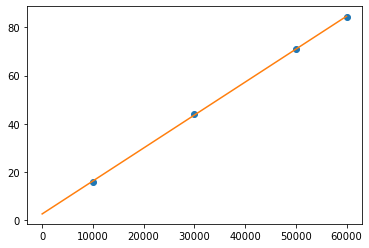

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#4019 42.43043494224548 40199  40199  281.12068939208984 120600 820.6956114768982  201001 1340  361803 2563.249900817871
x = [[10000],[30000],[50000],[60000] ]
y = [[16],[44],[71],[84.41726922988892]]
reg = LinearRegression().fit(x,y)
x_pre = np.linspace(0,60000,5)
x_pre = x_pre.reshape(-1,1)
y_pre = reg.predict(x_pre)
plt.plot(x, y,'o')
plt.plot(x_pre, y_pre)
a = reg.coef_
b = reg.intercept_
print(a,b)
plt.show()

[[0.00231278]] [-15.11025307]


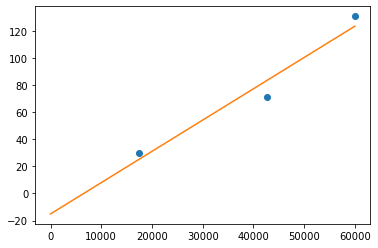

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#4019 42.43043494224548 40199  40199  281.12068939208984 120600 820.6956114768982  201001 1340  361803 2563.249900817871
x = [[17400],[42600],[60000] ]
y = [[30.202638864517212],[71],[131]]
reg = LinearRegression().fit(x,y)
x_pre = np.linspace(0,60000,5)
x_pre = x_pre.reshape(-1,1)
y_pre = reg.predict(x_pre)
plt.plot(x, y,'o')
plt.plot(x_pre, y_pre)
a = reg.coef_
b = reg.intercept_
print(a,b)
plt.show()

In [14]:
60000/71

845.0704225352113

In [15]:
 60000/106.477

563.5019769527692

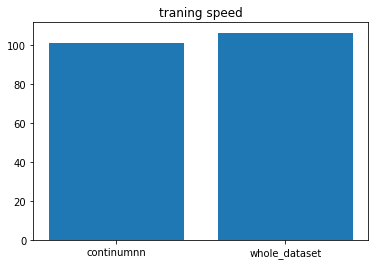

In [16]:
training_time = [(30+71), 106.477]
training_type = ['continumnn', 'whole_dataset']
plt.bar(training_type, training_time)
plt.title('traning speed')
plt.show()

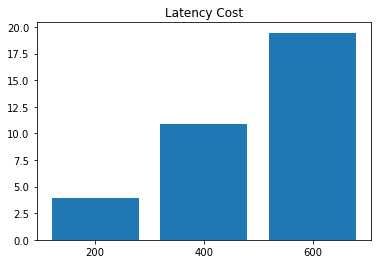

In [17]:
Latency_Cost = [3.895635198, 10.858555937999999, 19.466332678]
data_size = ['200','400', '600']
plt.bar(data_size, Latency_Cost)
plt.title('Latency Cost')
plt.show()